## Trading Strategy based on the MACD compare to the Buy-and-Hold Portfolio Strategy

[*********************100%***********************]  1 of 1 completed


Mean: 0.000535587991978574
Variance: 0.00023722733023169668
Skewness: 0.14801962588705408
Kurtosis: 5.0279861433815585
Ticker            AMGN  Log_Return
Date                              
2010-01-04   40.265972         NaN
2010-01-05   39.917175   -0.008700
2010-01-06   39.617210   -0.007543
2010-01-07   39.254440   -0.009199
2010-01-08   39.603249    0.008847
...                ...         ...
2021-12-27  203.135071    0.006147
2021-12-28  203.676346    0.002661
2021-12-29  205.327271    0.008073
2021-12-30  204.307846   -0.004977
2021-12-31  202.954636   -0.006645

[3021 rows x 2 columns]


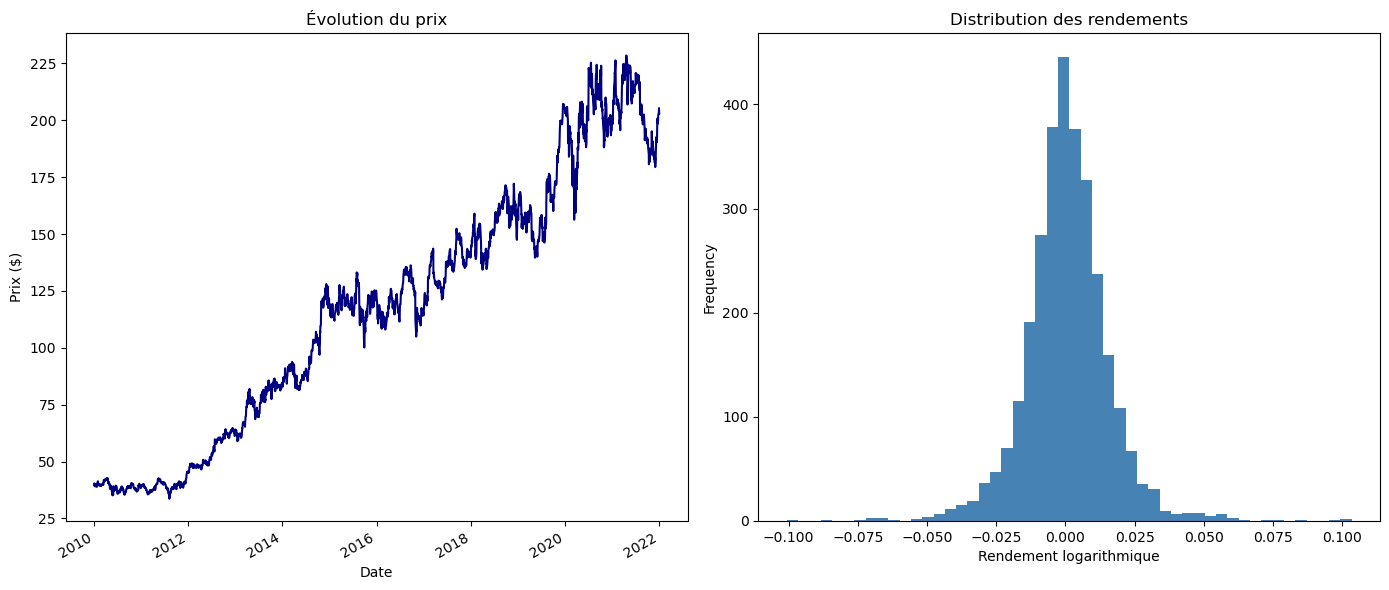

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.stattools import acf 
from scipy import stats 
import statsmodels.api as sm 
import yfinance as yf

#We import data and calcalute various metrics
data=data = yf.download('AMGN', start='2010-01-01', end='2022-01-01')['Close']


data['Log_Return'] = np.log(data['AMGN'] / data['AMGN'].shift(1))


returns = data['Log_Return'].dropna()
mean_return = returns.mean()
variance_return = returns.var()
skewness_return = returns.skew()
kurtosis_return = returns.kurtosis()

print(f"Mean: {mean_return}")
print(f"Variance: {variance_return}")
print(f"Skewness: {skewness_return}")
print(f"Kurtosis: {kurtosis_return}")
print(data)


# We print returns and distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
data['AMGN'].plot(title='Évolution du prix', color='navy')
plt.xlabel('Date')
plt.ylabel('Prix ($)')

plt.subplot(1, 2, 2)
data['Log_Return'].plot.hist(bins=50, title='Distribution des rendements', color='steelblue')
plt.xlabel('Rendement logarithmique')
plt.tight_layout()
plt.show()



The skewness is aove 0 so the returns are positively skew and the kurtosis is above 3 so there is a fat tail. So, the returns are not normally distributed


In [ ]:
#we perform the bow_pierce test
autocorr = acf(returns,nlags=20,fft=False)
T = len(returns)
Box_Pierce = T*np.sum(autocorr[1:]**2)
print("Box-Pierce statistics: " + str(round(Box_Pierce,2)))
critical = stats.chi2.ppf(0.99,len(autocorr[1:]))
print('Critical value of the Box-Pierce test at 99% confidence level: ' + str(round(critical,2)))

There is evidence of autocorrelation because the Box-Pierce test value is above the critical value. So we can say that past returns have explanatory power on the future returns

We calculate the MACD as the difference between the short term exponential moving average and a long term EMA
The signal line is a 9-period exponential moving average of the MACD line. When the MACD is above the signal line it trigger
a buying signal. When its below it trigger a selling signal. To define the time of each period, we used the MACD 12, 26, 9 strategy

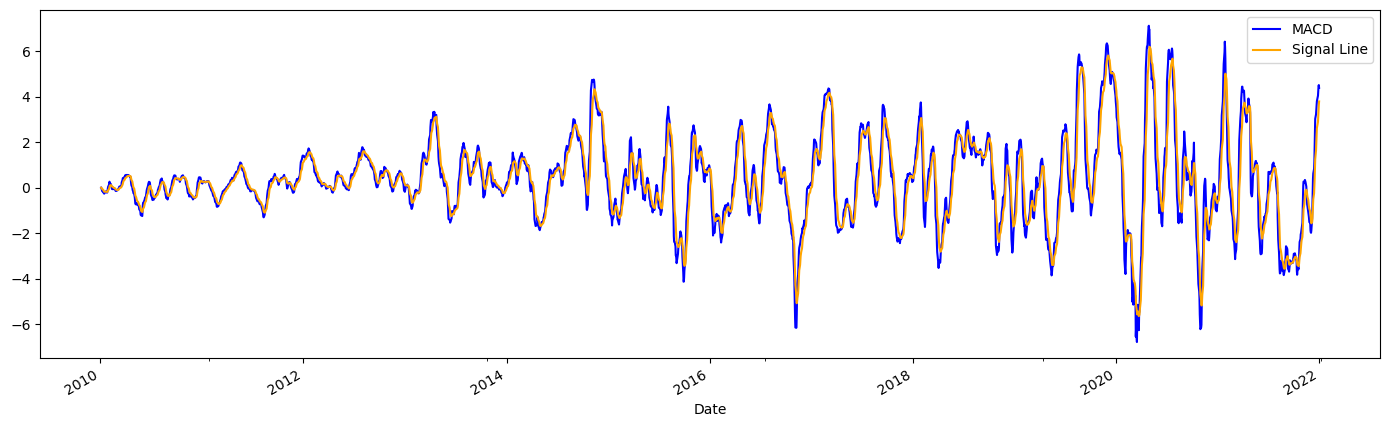

In [65]:

def calculate_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()

    # we calculate the MACD line and the signal line 
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()

    return macd, signal_line

data['MACD'], data['Signal_Line'] = calculate_macd(data['AMGN'])

# we define buy and sell signals
data['Buy_Signal'] = np.where(data['MACD'] > data['Signal_Line'], 1, 0)
data['Sell_Signal'] = np.where(data['MACD'] < data['Signal_Line'], -1, 0)


# We plot signal
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 2, sharex=ax1)
data['MACD'].plot(color='blue', label='MACD')
data['Signal_Line'].plot(color='orange', label='Signal Line')
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
#We create our dummy variable buy 
data['Buy'] = 0
data.loc[data['MACD'] > data['Signal_Line'], 'Buy'] = 1


data.dropna(inplace=True)

# we perform the linear regression
X = sm.add_constant(data['Buy'])
model = sm.OLS(data['Log_Return'], X).fit()

print(model.summary())

beta_1 = model.params['Buy']
p_value = model.pvalues['Buy']

print(beta_1,p_value)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     62.00
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           4.75e-15
Time:                        18:58:17   Log-Likelihood:                 8349.2
No. Observations:                3020   AIC:                        -1.669e+04
Df Residuals:                    3018   BIC:                        -1.668e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.000     -4.233      0.0

Our dummy variable buy is an explanatory variable of the return because Beta is above 0 (0.004) and the p-value is below 5% (0.000). So, the test is statiscally significant. 

In [71]:
#We backctest our strategy and compare it to the buy-and-hold strategy
train_data = data[:int(0.5 * len(data))] 
test_data = data[int(0.5 * len(data)):]  


# we initialize the return of the strategy
test_data['Strategy_Return'] = 0  
asset_returns = test_data['Log_Return']  


for i in range(1, len(test_data)):
    if test_data['Buy_Signal'].iloc[i] == 1:  # Signal "Hold"
        test_data.iloc[i,len(test_data.columns)-1] = asset_returns.iloc[i]
    else:  # Signal "Do not hold"
        test_data.iloc[i, len(test_data.columns)-1] = 0

risk_free_daily = (1 + 0.03)**(1/252) - 1

# we calculate the metrics
average_return = test_data['Strategy_Return'].mean()  # Retour quotidien moyen
std_dev_return = test_data['Strategy_Return'].std()   # Écart-type des retours
sharpe_ratio = (average_return -risk_free_daily) / std_dev_return 


print(f"Mean MACD: {average_return}")
print(f"Mean Buy-and-Hold: {mean_return}")
print(f"Standard Deviation MACD: {std_dev_return}")
print(f"Standard Deviation Buy-and-Hold: {np.sqrt(variance_return)}")
print(f"Sharpe Ratio MACD: {sharpe_ratio}")
print(f"Sharpe Ratio Buy-and-Hold: {(mean_return-risk_free_daily)/np.sqrt(variance_return)}")


if mean_return < average_return:
    print('The strategy outperforms the buy-and-hold portfolio')
else:
    print('The strategy does not outperform the buy-and-hold portfolio')

Mean MACD: 0.0013361946560179081
Mean Buy-and-Hold: 0.000535587991978574
Standard Deviation MACD: 0.01031652481544542
Standard Deviation Buy-and-Hold: 0.01540218589134986
Sharpe Ratio MACD: 0.1181493733586132
Sharpe Ratio Buy-and-Hold: 0.027157462005379426
The strategy outperforms the buy-and-hold portfolio


C:\Users\Mathis\AppData\Local\Temp\ipykernel_4272\1966520101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Strategy_Return'] = 0
C:\Users\Mathis\AppData\Local\Temp\ipykernel_4272\1966520101.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.021369367278368825' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_data.iloc[i,len(test_data.columns)-1] = asset_returns.iloc[i]


The strategy have a average return larger than the Buy-and-Hold strategy on a daily-basis and volatility less important. Moreover the sharpe ratio is more important but the transactions cost are not taken into account.